<a href="https://colab.research.google.com/github/robgon-art/BIG.art/blob/main/BIG_art_Image_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on the Colab from OpenAI, here: [Glide text2im.ipynb](https://colab.research.google.com/github/openai/glide-text2im/blob/main/notebooks/text2im.ipynb)

In [ ]:
#@title Initialize the System

!nvidia-smi -L
!pip install git+https://github.com/openai/glide-text2im
from PIL import Image
from IPython.display import display
import torch

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')

!git clone https://github.com/cszn/BSRGAN.git
!wget https://github.com/cszn/KAIR/releases/download/v1.0/BSRGAN.pth -P BSRGAN/model_zoo
import sys
sys.path.append("/content/BSRGAN")

import torch
from torchvision import transforms as T

# from utils import utils_image as util
from models.network_rrdbnet import RRDBNet as net

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/content/BSRGAN/model_zoo/BSRGAN.pth"

bsrgan_model = net(in_nc=3, out_nc=3, nf=64, nb=23, gc=32, sf=4)
bsrgan_model.load_state_dict(torch.load(model_path), strict=True)
bsrgan_model.eval()
bsrgan_model = bsrgan_model.to(device)

!git clone https://github.com/CompVis/taming-transformers.git
!pip install ftfy omegaconf pytorch-lightning einops

!curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
!curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384

# !curl -L 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt' > wikiart_16384.ckpt
# !curl -L 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml' > wikiart_16384.yaml

print("line 47")
!wget https://download.pytorch.org/models/vgg16-397923af.pth --no-check-certificate -P /root/.cache/torch/hub/checkpoints/

import sys
sys.path.append('./taming-transformers')
from taming.models import vqgan
from omegaconf import OmegaConf
config = OmegaConf.load("vqgan_imagenet_f16_16384.yaml")    # wikiart_16384 vqgan_imagenet_f16_16384
vqgan_model = vqgan.VQModel(**config.model.params).to(device)
vqgan_model.eval().requires_grad_(False)
vqgan_model.init_from_ckpt("vqgan_imagenet_f16_16384.ckpt") # wikiart_16384 vqgan_imagenet_f16_16384

print("line 58")

def create_base_model(num_steps):
  options = model_and_diffusion_defaults()
  options['use_fp16'] = has_cuda
  options['timestep_respacing'] = str(num_steps) # use 100 diffusion steps for fast sampling
  model, diffusion = create_model_and_diffusion(**options)
  model.eval()
  if has_cuda:
    model.convert_to_fp16()
  model.to(device)
  model.load_state_dict(load_checkpoint('base', device))
  return model, diffusion, options

old_steps = 100
model, diffusion, options = create_base_model(100)

# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # fast27, use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))

old_seed = 42

random seed 25584


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Boston city skyline


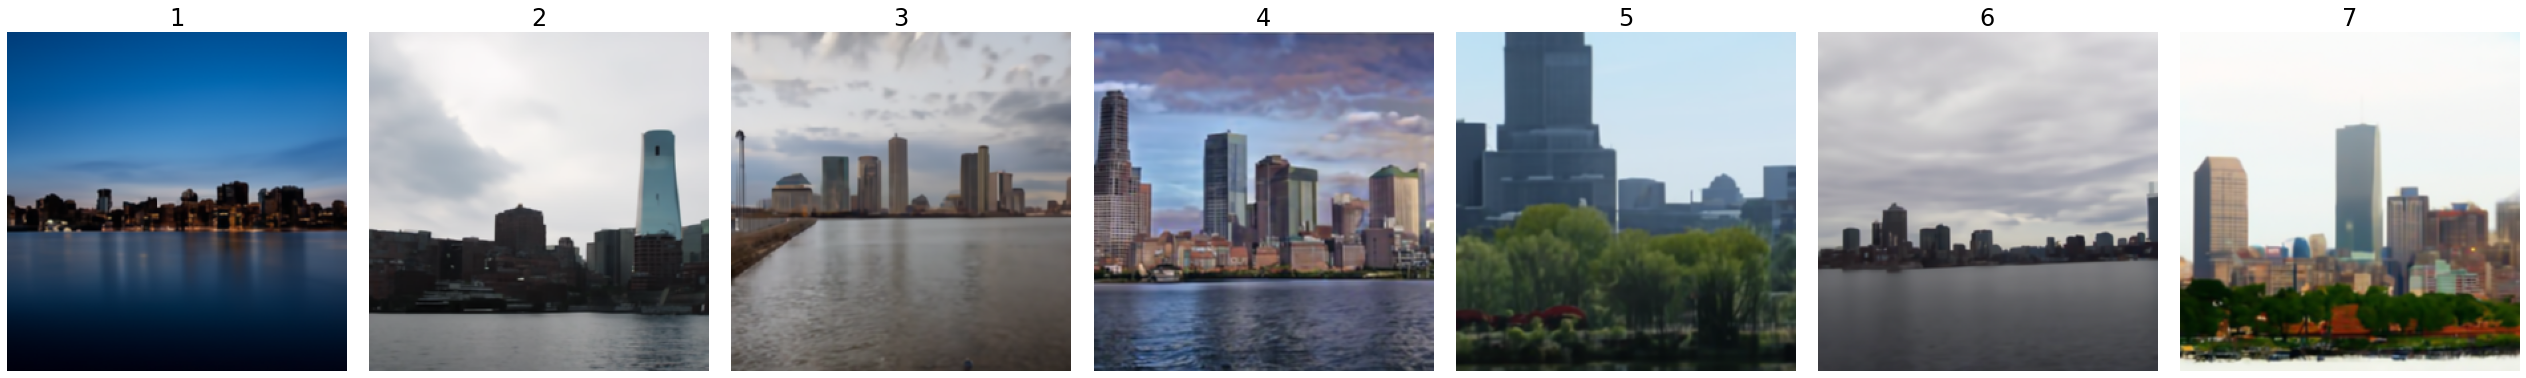

In [3]:
#@title Generate Thumbnails
# Sampling parameters
import random
import matplotlib.pyplot as plt
prompt = "Boston city skyline"  #@param {type:"string"}
num_steps = 400 #@param {type:"slider", min:10, max:1000, step:10}
random_seed = '25584' #@param ["new", "previous", "42"] {allow-input: true}

if random_seed == "new":
  seed = random.randint(0, 65536)
  old_seed = seed
elif random_seed == "previous":
  seed = old_seed
else:
  if random_seed.isnumeric():
    seed = int(random_seed)
    old_seed = seed
  else:
    seed = random.randint(0, 65536)
    old_seed = seed

print("random seed", seed)
torch.manual_seed(seed)

batch_size = 7
guidance_scale = 2.0 # 9.0 # 3.0

if old_steps != num_steps:
  model, diffusion, options = create_base_model(num_steps)
  old_steps = num_steps

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=torch.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=torch.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=torch.bool,
        device=device,
    ),
)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = torch.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = torch.cat([half_eps, half_eps], dim=0)
    return torch.cat([eps, rest], dim=1)

# Sample from the base model.
torch.cuda.empty_cache()
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()
torch.cuda.empty_cache()

# Show the output
# show_images(samples)

##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=torch.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=torch.tensor(
        [mask] * batch_size,
        dtype=torch.bool,
        device=device,
    ),
)

# Sample from the base model.
torch.cuda.empty_cache()
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=torch.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()
torch.cuda.empty_cache()

print(prompt)

# Show the output
scaled = ((up_samples + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
reshaped = scaled.permute(0, 2, 3, 1)
fig = plt.figure(figsize=(35, 6))

for i in range(7):
  fig.add_subplot(1, 7, i+1)
  img = Image.fromarray(reshaped.numpy()[i])
  plt.tight_layout(pad=0, w_pad=None)
  plt.title(i+1, fontsize=24)
  plt.axis("off")
  plt.imshow(img)
plt.show()

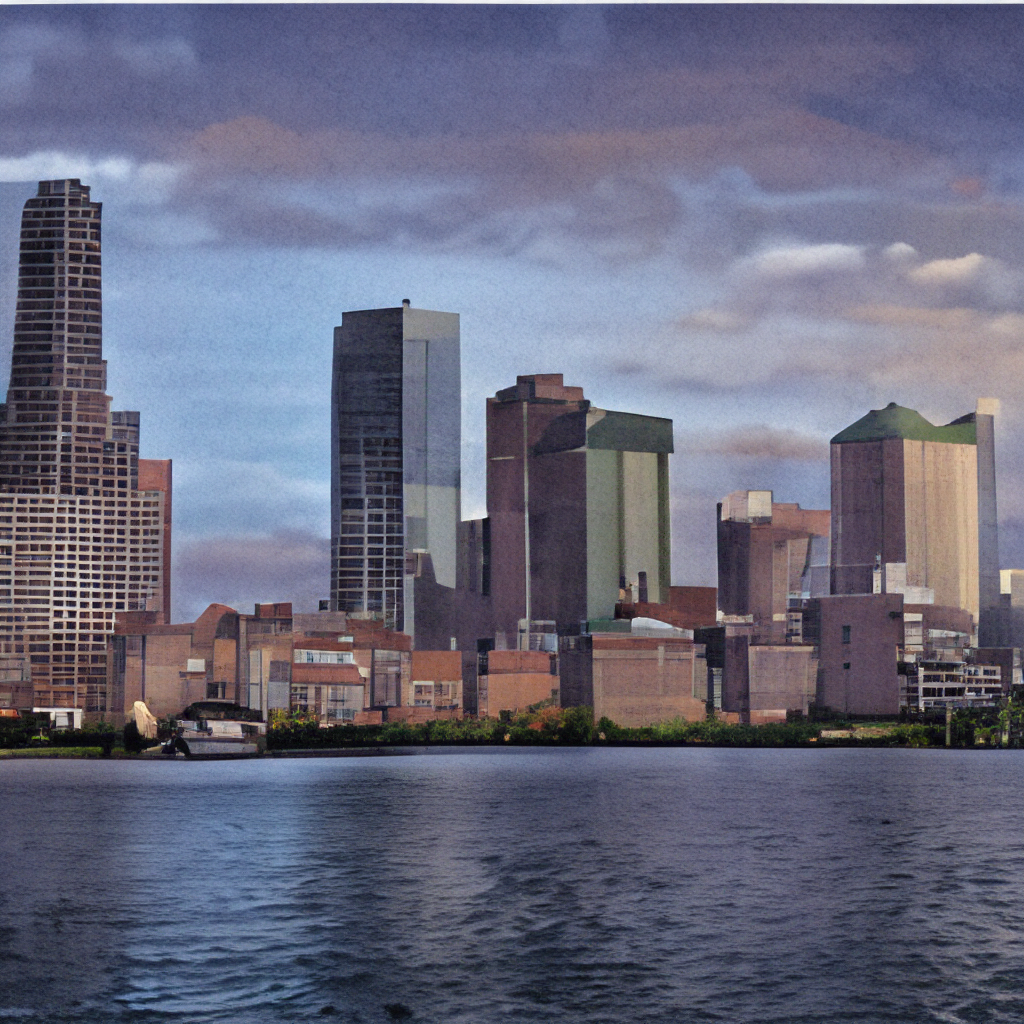

In [6]:
#@title Generate 1K Image

choose = 4 #@param {type:"slider", min:1, max:7, step:1}
texture_amount = 0.037 #@param {type:"slider", min:0, max:0.15, step:0.001}
texture_size = 7 #@param {type:"slider", min:1, max:25, step:2}
enhance_details = True #@param {type:"boolean"}

from torchvision import transforms as T
import IPython

small_img = samples[choose-1].add(1).div(2).clamp(min=0, max=1)
img = T.ToPILImage()(small_img)
img.save("output_256.png")
IPython.display.Image("output_256.png")

selected_img = up_samples[choose-1]
selected_img = selected_img.add(1).div(2)[None, :]

with torch.no_grad():
  torch.cuda.empty_cache()
  resized = bsrgan_model(selected_img)
  torch.cuda.empty_cache()

noise = torch.normal(0, texture_amount, 
  size=[resized.shape[0], 1, resized.shape[2], resized.shape[3]]).to(device)
noise = noise.repeat(1, 3, 1, 1)

noise_blured = T.GaussianBlur(kernel_size=texture_size, sigma=1)(noise)
noise_blured = noise*0.25 + noise_blured*0.75
resized = (resized+noise_blured)
final_image = resized.to(device)

if enhance_details:
  with torch.no_grad():
    torch.cuda.empty_cache()
    z, *_ = vqgan_model.encode(final_image * 2 - 1)
    final_image = vqgan_model.decode(z)[0].add(1).div(2).clamp(min=0, max=1)
    torch.cuda.empty_cache()
    final_image = final_image.clamp(min=0, max=1)
else:
    final_image = final_image[0].clamp(min=0, max=1)

img = T.ToPILImage()(final_image)
img.save("output_1k.png")
IPython.display.Image("output_1k.png")

In [7]:
#@title Generate 4K Image

with torch.no_grad():
  torch.cuda.empty_cache()
  resized = bsrgan_model(final_image[None, :]).clamp(min=0, max=1)
  torch.cuda.empty_cache()

noise = torch.normal(0, texture_amount, size=resized.shape).to(device)
noise_blured = T.GaussianBlur(kernel_size=texture_size, sigma=1)(noise)
noise_blured = noise*0.25 + noise_blured*0.75
resized = (resized+noise_blured).clamp(min=0, max=1)

img = T.ToPILImage()(resized[0])
img.save("output_4k.jpg", quality=100)
print("Saving image to output_4k.jpg")

Saving image to output_4k.jpg
